In [1]:
from leaguedata.data import get_history_dict
history = get_history_dict()

Generating train split:   0%|          | 0/2997254 [00:00<?, ? examples/s]

In [11]:
from leaguedata.util import find_streaks
from jax.tree_util import tree_flatten, tree_map

history_array = jnp.asarray(tree_flatten(tree_map(lambda x : x[-85:], history))[0])
win_streaks, loss_streaks = jax.vmap(find_streaks)(history_array)

In [ ]:
true_counts_wins, bins = np.histogram(
        result_df[result_df['Type'] == 'Win']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )

true_counts_loss, bins = np.histogram(
        result_df[result_df['Type'] == 'Loss']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )

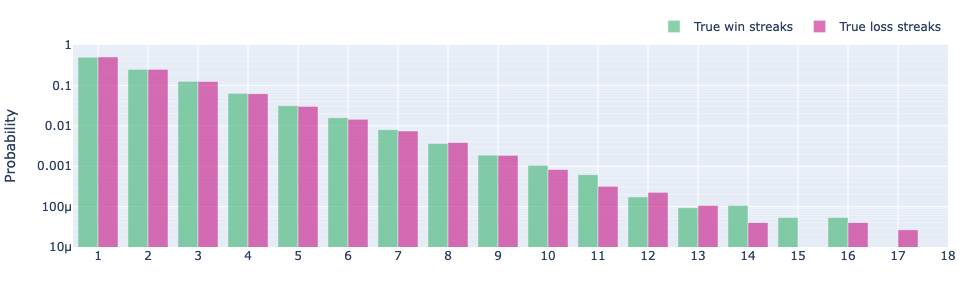

In [36]:
import plotly.graph_objects as go

fig = go.Figure()

bins = dict( # bins used for histogram
        start=1,
        end=30,
        size=1
    )


fig.add_trace(
    go.Bar(
        x=np.arange(1, 20, 1),
        y=true_counts_wins,
        name='True win streaks',
        marker_color='rgba(60, 179, 113, 0.6)',
    )
)

fig.add_trace(
    go.Bar(
        x=np.arange(1, 20, 1),
        y=true_counts_loss,
        name='True loss streaks',
        marker_color='rgba(199, 21, 133, 0.6)',
    )
)

fig.update_xaxes(
    tickmode='linear', 
    tick0=1, 
    dtick=1, 
    range=[0.5, 18.],
    showgrid=True, 
    title='',
    minor=dict(showgrid=True)
)

fig.update_yaxes(
    type='log', 
    title='Probability', 
    range=[-5, 0], 
    showgrid=True, 
    minor=dict(showgrid=True)
)

fig.update_layout(
    hovermode="x",
    margin=dict(l=20, r=20, t=20, b=20),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    width=600, height=300,  
)

fig.show()

with open("docs/loserQ/assets/history_streak_histogram.json", "w") as f:
    f.write(fig.to_json())

In [6]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
from leaguedata.model import DTMCModel

markov = DTMCModel(1)

def single_history(key, probs_keys, number_of_games):
    probs = jnp.empty((2 ** 1))
    
    for i, state in enumerate(markov.get_states()):
        probs = probs.at[i].set(probs_keys[sum(state)])

    return markov.build_process(number_of_games, probs=probs).sample(1, seed=key)[0]

In [7]:
import pandas as pd 
from tqdm.notebook import trange 

counts_win_list = []
counts_loss_list = []
counts_win_ref = []
counts_loss_ref = []

for i in trange(100):
    
    probs_keys = {
    1.: np.random.normal(50.54/100, 0.14/100, size=3100),
    0.: np.random.normal(49.81/100, 0.14/100, size=3100)
    }

    keys = jax.random.split(PRNGKey(i), 3100)
    history_categorical = np.asarray(
        jax.vmap(lambda key, probs: single_history(key, probs, 100)
                 )(keys, probs_keys))
    
    history = np.apply_along_axis(markov.categorical_serie_to_binary, 1, history_categorical)

    list_of_streaks = []
    
    for i in range(3100): 
        list_of_streaks.extend([x + (tier,) for x in find_streaks(history[i].astype(bool)[-85:])])
            
    mock_df = pd.DataFrame(data=list_of_streaks, columns = ["Type", "Length", "Tier"])
    mock_df['Type'] = mock_df['Type'].map({True: 'Win', False: 'Loss'})
    
    counts_wins, bins = np.histogram(
        mock_df[mock_df['Type'] == 'Win']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )
    
    counts_loss, bins = np.histogram(
        mock_df[mock_df['Type'] == 'Loss']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )
    
    counts_win_list.append(counts_wins)
    counts_loss_list.append(counts_loss)
    
counts_win_list = np.asarray(counts_win_list)
counts_loss_list = np.asarray(counts_loss_list)

mean_win_counts = np.mean(counts_win_list, axis=0)
std_win_counts = np.std(counts_win_list, axis=0)

mean_loss_counts = np.mean(counts_loss_list, axis=0)
std_loss_counts = np.std(counts_loss_list, axis=0)

residuals_win = np.nan_to_num((win_true_freq - mean_win_counts)/std_win_counts)
residuals_loss = np.nan_to_num((loss_true_freq - mean_loss_counts)/std_loss_counts)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
true_counts_wins, bins = np.histogram(
        result_df[result_df['Type'] == 'Win']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )

true_counts_loss, bins = np.histogram(
        result_df[result_df['Type'] == 'Loss']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )

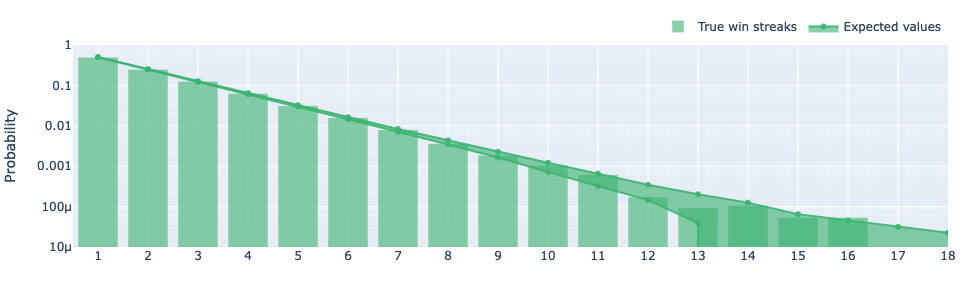

In [37]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=np.arange(1, 20, 1),
        y=true_counts_wins,
        name='True win streaks',
        marker_color='rgba(60, 179, 113, 0.6)',
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(1, 20, 1),
        y=mean_win_counts - 2*std_win_counts,
        line=dict(color='rgba(60, 179, 113, 0.9)'),
        name='Expected values',
        showlegend=False,
        legendgroup='fake_lose'
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(1, 20, 1),
        y=mean_win_counts + 2*std_win_counts,
        line=dict(color='rgba(60, 179, 113, 0.9)'),
        fillcolor='rgba(60, 179, 113, 0.6)',
        fill='tonexty',
        name='Expected values',
        legendgroup='fake_lose'
    )
)

fig.update_xaxes(
    tickmode='linear', 
    tick0=1, 
    dtick=1, 
    range=[0.5, 18.],
    showgrid=True, 
    title='',
    minor=dict(showgrid=True)
)

fig.update_yaxes(
    type='log', 
    title='Probability', 
    range=[-5, 0], 
    showgrid=True, 
    minor=dict(showgrid=True)
)

fig.update_layout(
    hovermode="x",
    margin=dict(l=20, r=20, t=20, b=20),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    width=600, height=300,  
)

# Save to JSON file
with open("docs/loserQ/assets/mock_streak_histogram_win.json", "w") as f:
    f.write(fig.to_json(pretty=True))
    
fig.show()

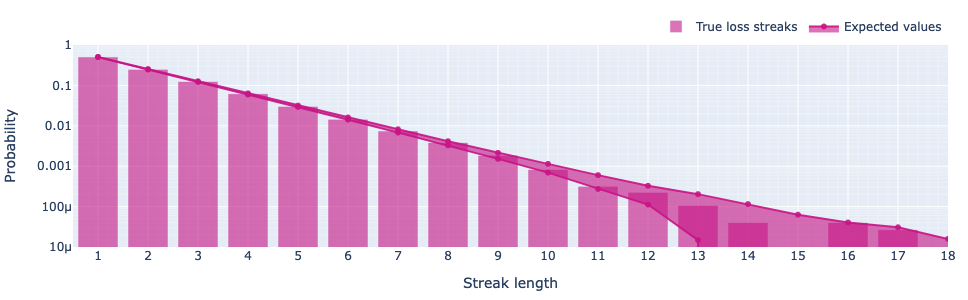

In [38]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=np.arange(1, 20, 1),
        y=true_counts_loss,
        name='True loss streaks',
        marker_color='rgba(199, 21, 133, 0.6)',
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(1, 20, 1),
        y=mean_loss_counts - 2*std_loss_counts,
        line=dict(color='rgba(199, 21, 133, 0.9)'),
        name='Expected values',
        showlegend=False,
        legendgroup='fake_lose'
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(1, 20, 1),
        y=mean_loss_counts + 2*std_loss_counts,
        line=dict(color='rgba(199, 21, 133, 0.9)'),
        fillcolor='rgba(199, 21, 133, 0.6)',
        fill='tonexty',
        name='Expected values',
        legendgroup='fake_lose'
    )
)

fig.update_xaxes(
    tickmode='linear', 
    tick0=1, 
    dtick=1, 
    range=[0.5, 18.],
    title='Streak length',
    showgrid=True, 
    minor=dict(showgrid=True)
)

fig.update_yaxes(
    type='log', 
    title='Probability', 
    range=[-5, 0], 
    showgrid=True, 
    minor=dict(showgrid=True)
)

fig.update_layout(
    hovermode="x",
    margin=dict(l=20, r=20, t=20, b=20),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    width=600, height=300,  
)

# Save to JSON file
with open("docs/loserQ/assets/mock_streak_histogram_loss.json", "w") as f:
    f.write(fig.to_json(pretty=True))
    
fig.show()

In [43]:
from leaguedata.model import generate_obvious_loser_q, generate_nasty_loser_q

counts_win_list_loserq = []
counts_loss_list_loserq = []

for i in trange(100):
    
    history = generate_nasty_loser_q(number_of_players=3100, key=PRNGKey(i))

    list_of_streaks = []
    
    for i in range(3100): 
        list_of_streaks.extend([x + (tier,) for x in find_streaks(history[i].astype(bool))])
            
    mock_df = pd.DataFrame(data=list_of_streaks, columns = ["Type", "Length", "Tier"])
    mock_df['Type'] = mock_df['Type'].map({True: 'Win', False: 'Loss'})
    
    counts_wins, bins = np.histogram(
        mock_df[mock_df['Type'] == 'Win']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )
    
    counts_loss, bins = np.histogram(
        mock_df[mock_df['Type'] == 'Loss']['Length'], 
        bins=range(1, 20, 1),
        density=True
    )
    
    counts_win_list_loserq.append(counts_wins)
    counts_loss_list_loserq.append(counts_loss)
    
counts_win_list_loserq = np.asarray(counts_win_list_loserq)
counts_loss_list_loserq = np.asarray(counts_loss_list_loserq)

  0%|          | 0/100 [00:00<?, ?it/s]